<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn and Salvus</h1>
</div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [7]:
import os
import subprocess
from pprint import pprint

In [3]:
import toml
import numpy as np
import matplotlib.pyplot as plt
import h5py
import segyio

In [4]:
# Set numerical precision
# DTYPE = np.float64

In [5]:
# Imports for Cervino
from cervino import *

In [ ]:
# Imports for Salvus
# Workflow management
import salvus_flow.api

# Specific objects to aid in setting up simulations
from pyasdf import ASDFDataSet
from salvus_mesh.simple_config import basic_mesh
from salvus_flow.simple_config import (
    CartesianVectorSource2D, CartesianReceiver2D, RickerSTF,
    WaveformSimulation, AbsorbingBoundary)

<div class="alert alert-info">
    <h2>General setup</h2>
</div>

In [8]:
general_dict = get_general_dict(solver='matterhorn')
pprint(general_dict)

{'desc': 'Give me a name!',
 'site': 'aug04',
 'solver': 'matterhorn',
 'user': 'bfilippo'}


<div class="alert alert-info">
    <h2>Domain setup</h2>
</div>

In [9]:
domain = AcousticDomain()

In [10]:
# Set the models
domain.set_model_from_hdf5('marmousi_elastic_2d.h5', geometry=False)

In [12]:
pprint(domain.get_domain_dict())

{'dimension': 3,
 'geometry': {'cell-size': (1.25, 1.25, 1.25),
              'number-of-cells': (13601, 1, 2801),
              'origin': (0.0, 0.0, 0.0)},
 'model': {'filename': 'marmousi_elastic_2d.h5', 'format': 'hdf5'}}


<div class="alert alert-info">
    <h2>Time and frequency setup</h2>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also directly define the number of time steps.

In [13]:
time_step_in_seconds = 1e-4
start_time_in_seconds = -0.1
# time_shift_in_seconds = 1.0
end_time_in_seconds = 0.1

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

In [180]:
# This will also become a function to be consistent with the other sections
time_dict = get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

In [15]:
pprint(time_dict)

{'number-of-timesteps': 2000, 'time-step-in-seconds': 0.0001}


<div class="alert alert-info">
    <h2>Input setup</h2>
</div>

In [16]:
# Use a Ricker wavelet as source time function
center_frequency = 30.0
stf = RickerWavelet(t, fc=center_frequency, delay=0.)

In [24]:
# Define a point source
name = "source0"
location = (400.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

source0 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [28]:
pprint(source0.get_source_dict())

{'location': (400.0, 0.0, 20.0),
 'source-time-function': {'center-frequency': 30.0,
                          'time-shift-in-seconds': 0.0,
                          'wavelet': 'ricker'},
 'spatial-type': 'fz',
 'spatial-weights': 1.0}


In [26]:
# Define another point source
name = "source1"
location = (1400.0, 0.0, 40.0)
spatial_type = "fx"
scale = 1.

source1 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [27]:
pprint(source1.get_source_dict())

{'location': (1400.0, 0.0, 40.0),
 'source-time-function': {'center-frequency': 30.0,
                          'time-shift-in-seconds': 0.0,
                          'wavelet': 'ricker'},
 'spatial-type': 'fx',
 'spatial-weights': 1.0}


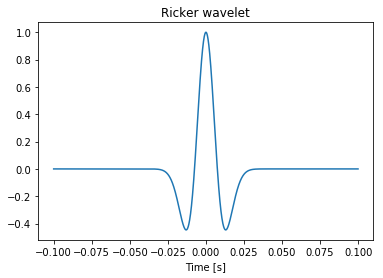

In [31]:
# Plot the source time function
plt.plot(t, source0.stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')

<div class="alert alert-info">
    <h2>Output setup</h2>
</div>

In [167]:
start_timestep = 0
end_timestep = 5000
timestep_increment = 10

gather = ShotGather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [168]:
n = domain.get_domain_dict()['geometry']['number-of-cells']
d = domain.get_domain_dict()['geometry']['cell-size']

# Number of receivers
nr = n[0]
# Receiver z-value
rz0 = 20.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nr * d[0]

In [169]:
# Define receivers
rec0 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather')
rec1 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename='vx_gather')


In [170]:
rec1

{'receiver-origin': (0.0, 0.0, 20.0),
 'receiver-increment': (1.25, 0.0, 0.0),
 'number-of-receivers': 13601,
 'attribute': 'V10X',
 'filename-prefix': 'vx_gather'}

In [171]:
pprint(gather.get_receiver_dict())

{'end-timestep': 5000,
 'format': 'su',
 'receivers': [{'attribute': 'V01Z',
                'filename-prefix': 'vz_gather',
                'number-of-receivers': 13601,
                'receiver-increment': (1.25, 0.0, 0.0),
                'receiver-origin': (0.0, 0.0, 20.0)},
               {'attribute': 'V10X',
                'filename-prefix': 'vx_gather',
                'number-of-receivers': 13601,
                'receiver-increment': (1.25, 0.0, 0.0),
                'receiver-origin': (0.0, 0.0, 20.0)}],
 'start-timestep': 0,
 'timestep-increment': 10,
 'type': 'shot_gather'}


<div class="alert alert-info">
    <h2>Physics setup</h2>
</div>

<div class="alert alert-info">
    <h2>Generate TOML file</h2>
</div>

In [172]:
# Generate the complete input file.
input_file_dict = {
    "general": get_general_dict(),
    "domain": domain.get_domain_dict(),
    "time": time_dict,
    "source": {"point-source": [source0.get_source_dict(), source1.get_source_dict()]},
    "output": {"gather": gather.get_receiver_dict()},
}

In [173]:
# Write the input file in TOML format
with open("marmousi_for_cervino.toml", "w") as f:
#     toml.dump(input_file_dict, f)
    toml.dump(input_file_dict, f, encoder=toml.TomlNumpyEncoder())

In [174]:
# Look at the file we've written
!cat "marmousi_for_cervino.toml"

[general]
user = "bfilippo"
site = "aug04"
solver = "matterhorn"
desc = "Give me a name!"

[domain]
dimension = 3

[time]
time-step-in-seconds = 0.0001
number-of-timesteps = 2000

[source]
[[source.point-source]]
location = [ 400.0, 0.0, 20.0,]
spatial-type = "fz"
spatial-weights = 1.0

[source.point-source.source-time-function]
center-frequency = 30.0
wavelet = "ricker"
time-shift-in-seconds = 0.0
[[source.point-source]]
location = [ 1400.0, 0.0, 40.0,]
spatial-type = "fx"
spatial-weights = 1.0

[source.point-source.source-time-function]
center-frequency = 30.0
wavelet = "ricker"
time-shift-in-seconds = 0.0

[domain.geometry]
origin = [ 0.0, 0.0, 0.0,]
number-of-cells = [ 13601, 1, 2801,]
cell-size = [ 1.25, 1.25, 1.25,]

[domain.model]
filename = "marmousi_elastic_2d.h5"
format = "hdf5"

[output.gather]
start-timestep = 0
end-timestep = 5000
timestep-increment = 10
format = "su"
type = "shot_gather"
[[output.gather.receivers]]
receiver-origin = [ 0.0, 0.0, 20.0,]
receiver-increment =

In [175]:
pprint(input_file_dict)

{'domain': {'dimension': 3,
            'geometry': {'cell-size': (1.25, 1.25, 1.25),
                         'number-of-cells': (13601, 1, 2801),
                         'origin': (0.0, 0.0, 0.0)},
            'model': {'filename': 'marmousi_elastic_2d.h5', 'format': 'hdf5'}},
 'general': {'desc': 'Give me a name!',
             'site': 'aug04',
             'solver': 'matterhorn',
             'user': 'bfilippo'},
 'output': {'gather': {'end-timestep': 5000,
                       'format': 'su',
                       'receivers': [{'attribute': 'V01Z',
                                      'filename-prefix': 'vz_gather',
                                      'number-of-receivers': 13601,
                                      'receiver-increment': (1.25, 0.0, 0.0),
                                      'receiver-origin': (0.0, 0.0, 20.0)},
                                     {'attribute': 'V10X',
                                      'filename-prefix': 'vx_gather',
              

In [176]:
input_file_dict_from_toml = toml.load('marmousi_for_cervino.toml')

In [177]:
pprint(input_file_dict_from_toml)

{'domain': {'dimension': 3,
            'geometry': {'cell-size': [1.25, 1.25, 1.25],
                         'number-of-cells': [13601, 1, 2801],
                         'origin': [0.0, 0.0, 0.0]},
            'model': {'filename': 'marmousi_elastic_2d.h5', 'format': 'hdf5'}},
 'general': {'desc': 'Give me a name!',
             'site': 'aug04',
             'solver': 'matterhorn',
             'user': 'bfilippo'},
 'output': {'gather': {'end-timestep': 5000,
                       'format': 'su',
                       'receivers': [{'attribute': 'V01Z',
                                      'filename-prefix': 'vz_gather',
                                      'number-of-receivers': 13601,
                                      'receiver-increment': [1.25, 0.0, 0.0],
                                      'receiver-origin': [0.0, 0.0, 20.0]},
                                     {'attribute': 'V10X',
                                      'filename-prefix': 'vx_gather',
              

In [178]:
for rec in input_file_dict_from_toml['output']['gather']['receivers']:
    print(rec)

{'receiver-origin': [0.0, 0.0, 20.0], 'receiver-increment': [1.25, 0.0, 0.0], 'number-of-receivers': 13601, 'attribute': 'V01Z', 'filename-prefix': 'vz_gather'}
{'receiver-origin': [0.0, 0.0, 20.0], 'receiver-increment': [1.25, 0.0, 0.0], 'number-of-receivers': 13601, 'attribute': 'V10X', 'filename-prefix': 'vx_gather'}


<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

In [179]:
# Convert TOML file to the standard Matterhorn input file
# mh_file = toml_to_mh('matterhorn_input_file.toml')
mh_file = toml_to_mh('marmousi_for_cervino.toml')
!cat marmousi_for_cervino.sim

<grid>
origin 0.0 0.0 0.0
number_of_cells 13601 1 2801
cell_size 1.25 1.25 1.25
</grid>

<decomposition>
number_of_nodes 1 1 1
number_of_cells_per_node_x 13601
number_of_cells_per_node_y 1
number_of_cells_per_node_z 2801
</decomposition>

<time>
number_of_timesteps 2000
timestep_size 0.0001
</time>

<model>
type acoustic
format bin
filename_prefix ./marmousi_elastic_2d
</model>

<simulation>
type acoustic_2d
order_time_operator 2
spatial_operator taylor_4
freesurface true
bc_type pml
pml_width_in_gridpoints 10
pml_power 4
pml_frequency 30.0
pml_damping_vel 3000
</simulation>

<input>
type z_source
location 400.0 0.0 20.0
wavelet ricker
central_frequency 30.0
spread trilinear
scale_factor 1.0
shift 1
</input>

<output>
type shot_gather
format su
start_timestep 0
end_timestep 5000
timestep_increment 10
attribute V01Z
filename_prefix vz_gather
receiver_origin 0.0 0.0 20.0
number_of_receivers 13601
receiver_increment 1.25 0.0 0.0
</output>

<output>
type shot_gather
format su
start_timeste

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [82]:
# Run
def run():
    process = subprocess.Popen('matterhorn {}'.format(mh_file), stdout = subprocess.PIPE, stderr = subprocess.STDOUT, shell = True)

#     while process.poll() is None:
#         line_out = process.stdout.readline()
#         line_err = process.stderr.readline()
#         print(line_out)
#         print(line_err)
    while process.poll() is None:
        line = process.stdout.readline().rstrip()
#         if not line:
#             break
        yield line

In [83]:
for line in run():
    print(line)

b'The OpenMP version is: 201611'
b'Start time is Tue Jun 18 15:31:23 2019'
b''
b'OpenMP used. Maximum number of threads is 16'
b''
b'Input control parameter file is marmousi_for_cervino.sim'
b'<grid>'
b'origin 0.0 0.0 0.0'
b'number_of_cells 13601 1 2801'
b'cell_size 1.25 1.25 1.25'
b'</grid>'
b'<decomposition>'
b'number_of_nodes 1 1 1'
b'number_of_cells_per_node_x 13601'
b'number_of_cells_per_node_y 1'
b'number_of_cells_per_node_z 2801'
b'</decomposition>'
b'<time>'
b'number_of_timesteps 2000'
b'timestep_size 0.0001'
b'</time>'
b'<model>'
b'type acoustic'
b'format bin'
b'filename_prefix ./marmousi_elastic_2d'
b'</model>'
b'<simulation>'
b'type acoustic_2d'
b'order_time_operator 2'
b'spatial_operator taylor_4'
b'freesurface true'
b'bc_type pml'
b'pml_width_in_gridpoints 10'
b'pml_power 4'
b'pml_frequency 30.0'
b'pml_damping_vel 3000'
b'</simulation>'
b'<input>'
b'type z_source'
b'location 400.0 0.0 20.0'
b'wavelet ricker'
b'central_frequency 30.0'
b'spread trilinear'
b'scale_factor 1.0'

KeyboardInterrupt: 

In [ ]:
# Show output
print('Have {} bytes in stdout:\n{}'.format(len(process.stdout), process.stdout.decode('utf-8')))

<div class="alert alert-info">
    <h3>Matterhorn (Euler)</h3>
</div>

In [127]:
# Create script

job_name = 'cervino'
cores = 24
input_file = mh_file

script = []

script.append('#!/bin/bash')

# Load modules
script.append('module load new')
script.append('module load intel/16.0.2.181')
script.append('module load open_mpi')

script.append("bsub -n {1} -N -B -J \"{0}\" -o {0}.out -e {0}.err \'export OMP_NUM_THREADS={1}; matterhorn {2}\'".format(job_name, cores, input_file))

In [128]:
print(script)

['#!/bin/bash', 'module load new', 'module load intel/16.0.2.181', 'module load open_mpi', 'bsub -n 24 -N -B -J "cervino" -o cervino.out -e cervino.err \'export OMP_NUM_THREADS=24; matterhorn marmousi_for_cervino.sim\'']


In [129]:
mh_script = 'script.sh'
with open(mh_script, 'w') as f:
    # Further file processing goes here
    f.writelines('\n'.join(script))

In [ ]:
# Copy input file and script to the appropriate folder

In [93]:
from fabric import Connection

In [130]:
# Submit the job (via ssh)
euler = Connection('euler.ethz.ch')

In [131]:
mh_dir = '/cluster/home/bfilippo/tests/cervino'

result = euler.put(mh_file, mh_dir)
result = euler.put(mh_script, mh_dir)

In [132]:
# Submit the job
result = euler.run('cd {} && bsub < {}'.format(mh_dir, mh_script), hide=False)

Generic job.


Job <93554560> is submitted to queue <normal.4h>.


In [133]:
# Extract the job id
import re
jobid = re.findall(r'(?<=<)[\d]+(?=>)', result.stdout)[0]
print(jobid)

93554560


In [134]:
# Check the status of the job
result = euler.run('bjobs {}'.format(jobid), hide=False)

JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
93554560   bfilipp PEND  normal.4h  eu-login-06             *vino.sim' Jun 19 12:33


In [ ]:
euler.run('matterhorn', hide=True)
msg = "Ran {0.command!r} on {0.connection.host}, got stdout:\n{0.stdout}"
print(msg.format(result))

<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [ ]:
# Set up a waveform simulation object.
simulation = WaveformSimulation(
    mesh=mesh, sources=source, receivers=receivers)

# Modify the start-time, end-time, and time-step of the simulation.
simulation.physics.wave_equation.end_time_in_seconds = end_time_in_seconds
simulation.physics.wave_equation.time_step_in_seconds = time_step_in_seconds
simulation.physics.wave_equation.start_time_in_seconds = start_time_in_seconds

# Make sure that Salvus _Compute_ will accept the current options.
simulation.validate()

In [ ]:
salvus_flow.api.run(
    site_name="aug04", input_file=simulation, ranks=8,
    output_folder="output", overwrite=True, get_all=True)

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [139]:
'{}/*.txt'.format(mh_dir)

'/cluster/home/bfilippo/tests/cervino/*.txt'

In [140]:
euler = Connection('euler.ethz.ch')
result = euler.get('{}/ciaone.txt'.format(mh_dir))

In [ ]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

In [ ]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 10)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=0.1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [ ]:
sufile.close()

<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [ ]:
def make_shotgather(asdf_file):
    """
    Generate a shotgather from an ASDF file.
    """
    
#     strain_map = {"xx": 0, "yy": 1, "xy": 2}
    displacement_map = {"x": 0, "y": 1}
    with ASDFDataSet(asdf_file, mode="r") as d:
        t = d.waveforms[d.waveforms.list()[0]].displacement
        arr = np.empty((len(d.waveforms.list()), t[0].stats.npts))
        for _i, tr in enumerate(d.waveforms):
            arr[_i, :] = tr.displacement[displacement_map["y"]].data
            
    return arr

In [ ]:
salvus = ASDFDataSet("output/receivers.h5", mode="r")

In [ ]:
salvus_gather = make_shotgather("./output/receivers.h5").T

In [ ]:
clip = 1e-1
vmin, vmax = -clip, clip

# Figure
figsize=(10, 10)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(salvus_gather, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=0.1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

<div class="alert alert-info">
    <h2>What's next</h2>
</div>

* This
* That